In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

In [4]:
# Load the model
model = load_model('/content/Unet_model_FINAL.h5', custom_objects={'dice_coefficient': dice_coefficient})


In [5]:
import matplotlib.pyplot as plt

def extract_probability_line(heatmap, percentile=99):
    thresholded = heatmap > np.percentile(heatmap, percentile)
    return np.argwhere(thresholded)

def find_intersections(left_probability_line, right_probability_line, horizontal_line_y, central_x):
    combined_probability_line = np.concatenate((left_probability_line, right_probability_line), axis=0)

    points_on_line = combined_probability_line[combined_probability_line[:, 0] == horizontal_line_y, :]

    left_points = points_on_line[points_on_line[:, 1] < central_x]
    right_points = points_on_line[points_on_line[:, 1] >= central_x]

    avg_left_point = np.mean(left_points, axis=0) if len(left_points) > 0 else None
    avg_right_point = np.mean(right_points, axis=0) if len(right_points) > 0 else None

    return avg_left_point, avg_right_point


def extract_landmarks(heatmap):
    return np.unravel_index(np.argmax(heatmap), heatmap.shape)

def calculate_centroid(points):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    centroid_x = sum(x_coords) / len(points)
    centroid_y = sum(y_coords) / len(points)
    return (centroid_x, centroid_y)

def is_point_on_probability_line(avg_point, probability_line, horizontal_line_y):
    points_on_line = probability_line[probability_line[:, 0] == horizontal_line_y, :]
    return any(avg_point[1] == point[1] for point in points_on_line)

def visualize_probability_lines_and_intersections(image, heatmaps, num_horizontal_lines=20):
    plt.imshow(image, cmap='gray')

    top_landmark = extract_landmarks(heatmaps[..., 0])
    bottom_landmark = extract_landmarks(heatmaps[..., 1])
    bottom_left_landmark = extract_landmarks(heatmaps[..., 2])
    bottom_right_landmark = extract_landmarks(heatmaps[..., 3])

    plt.scatter(top_landmark[1], top_landmark[0], c='magenta', s=50, marker='o', label='Top Landmark')
    plt.scatter(bottom_landmark[1], bottom_landmark[0], c='magenta', s=50, marker='o', label='Bottom Landmark')
    plt.scatter(bottom_left_landmark[1], bottom_left_landmark[0], c='magenta', s=50, marker='o', label='Bottom Left Landmark')
    plt.scatter(bottom_right_landmark[1], bottom_right_landmark[0], c='magenta', s=50, marker='o', label='Bottom Right Landmark')

    central_bottom_point = calculate_centroid([bottom_landmark, bottom_left_landmark, bottom_right_landmark])

    #plt.scatter(central_bottom_point[1], central_bottom_point[0], c='magenta', s=50, marker='o', label='Centroid')

    left_probability_line = extract_probability_line(heatmaps[..., -2])
    right_probability_line = extract_probability_line(heatmaps[..., -1])

    plt.scatter(left_probability_line[:, 1], left_probability_line[:, 0], c='blue', s=1, label='Left Probability Line')
    plt.scatter(right_probability_line[:, 1], right_probability_line[:, 0], c='green', s=1, label='Right Probability Line')

    horizontal_line_ys = np.linspace(top_landmark[0], central_bottom_point[0], num_horizontal_lines)[1:-1].astype(int)

    central_x = (top_landmark[1] + central_bottom_point[1]) / 2

    for y in horizontal_line_ys:
        avg_left_intersection, avg_right_intersection = find_intersections(left_probability_line, right_probability_line, y, central_x=central_x)

        if avg_left_intersection is not None:
            plt.scatter(avg_left_intersection[1], avg_left_intersection[0], c='red', s=10, label='Left Intersection' if y == horizontal_line_ys[0] else "")

        if avg_right_intersection is not None:
            plt.scatter(avg_right_intersection[1], avg_right_intersection[0], c='red', s=10, label='Right Intersection' if y == horizontal_line_ys[0] else "")

1/1 [==============================] - 0s 25ms/step


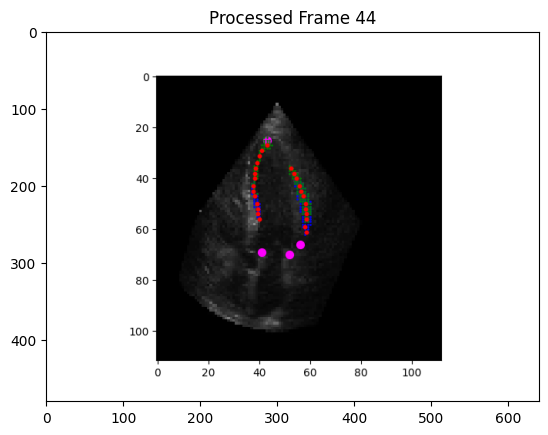

Finished processing and saving all frames.


In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def visualize_probability_lines_and_intersections(image, heatmaps, num_horizontal_lines=20):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    top_landmark = extract_landmarks(heatmaps[..., 0])
    bottom_landmark = extract_landmarks(heatmaps[..., 1])
    bottom_left_landmark = extract_landmarks(heatmaps[..., 2])
    bottom_right_landmark = extract_landmarks(heatmaps[..., 3])

    plt.scatter(top_landmark[1], top_landmark[0], c='magenta', s=50, marker='o', label='Top Landmark')
    plt.scatter(bottom_landmark[1], bottom_landmark[0], c='magenta', s=50, marker='o', label='Bottom Landmark')
    plt.scatter(bottom_left_landmark[1], bottom_left_landmark[0], c='magenta', s=50, marker='o', label='Bottom Left Landmark')
    plt.scatter(bottom_right_landmark[1], bottom_right_landmark[0], c='magenta', s=50, marker='o', label='Bottom Right Landmark')

    central_bottom_point = calculate_centroid([bottom_landmark, bottom_left_landmark, bottom_right_landmark])

    #plt.scatter(central_bottom_point[1], central_bottom_point[0], c='magenta', s=50, marker='o', label='Centroid')

    left_probability_line = extract_probability_line(heatmaps[..., -2])
    right_probability_line = extract_probability_line(heatmaps[..., -1])

    plt.scatter(left_probability_line[:, 1], left_probability_line[:, 0], c='blue', s=1, label='Left Probability Line')
    plt.scatter(right_probability_line[:, 1], right_probability_line[:, 0], c='green', s=1, label='Right Probability Line')

    horizontal_line_ys = np.linspace(top_landmark[0], central_bottom_point[0], num_horizontal_lines)[1:-1].astype(int)

    central_x = (top_landmark[1] + central_bottom_point[1]) / 2

    for y in horizontal_line_ys:
        avg_left_intersection, avg_right_intersection = find_intersections(left_probability_line, right_probability_line, y, central_x=central_x)

        if avg_left_intersection is not None:
            plt.scatter(avg_left_intersection[1], avg_left_intersection[0], c='red', s=10, label='Left Intersection' if y == horizontal_line_ys[0] else "")

        if avg_right_intersection is not None:
            plt.scatter(avg_right_intersection[1], avg_right_intersection[0], c='red', s=10, label='Right Intersection' if y == horizontal_line_ys[0] else "")

    # Convert the matplotlib plot to an OpenCV image
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Fetch the width and height
    width, height = fig.get_size_inches() * fig.get_dpi()

    # Convert to a NumPy array and then to an OpenCV image (BGR)
    img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)

    # Close the figure to prevent it from displaying in the notebook
    plt.close(fig)

    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Create a directory to save frames
frames_dir = '/content/frames'
os.makedirs(frames_dir, exist_ok=True)

# Read the video
cap = cv2.VideoCapture('/content/00003.avi')
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess, predict, and visualize as before
    frame_resized = cv2.resize(frame, (112, 112))
    frame_normalized = frame_resized.astype('float32') / 255.0
    heatmaps = model.predict(np.expand_dims(frame_normalized, axis=0))[0]
    frame_with_landmarks = visualize_probability_lines_and_intersections(frame_resized, heatmaps)

    # Save the processed frame as an image
    frame_path = os.path.join(frames_dir, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_path, frame_with_landmarks, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

    # Increment frame count
    frame_count += 1

# Release video capture
cap.release()

# Optional: Display an example frame (can be done for selected frames as needed)
plt.imshow(cv2.cvtColor(frame_with_landmarks, cv2.COLOR_BGR2RGB))  # Convert color from BGR to RGB
plt.title(f'Processed Frame {frame_count}')
plt.show()

print("Finished processing and saving all frames.")


In [ ]:
from google.colab import files
files.download('/content/frames')

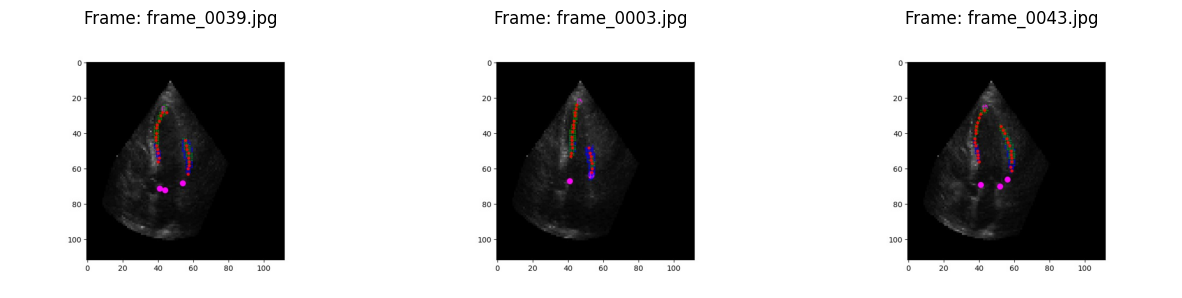

In [18]:
import cv2
import os
import random
import matplotlib.pyplot as plt

frames_dir = '/content/frames'

# Get a list of all saved frame paths
frame_files = os.listdir(frames_dir)
frame_files = [os.path.join(frames_dir, file) for file in frame_files]

# Randomly select 3 frame paths
random_frames = random.sample(frame_files, 3)

# Display the selected frames
plt.figure(figsize=(15, 5))
for i, frame_path in enumerate(random_frames, 1):
    frame = cv2.imread(frame_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB
    plt.subplot(1, 3, i)
    plt.imshow(frame)
    plt.title(f'Frame: {os.path.basename(frame_path)}')
    plt.axis('off')

plt.show()


In [ ]:
!pip install imageio

In [8]:
import imageio
import os

# Directory where frames are saved
frames_dir = '/content/frames'

# List to hold image data
images = []

# Read each frame from the directory and append it to the images list
for file_name in sorted(os.listdir(frames_dir)):
    if file_name.endswith('.jpg'):
        file_path = os.path.join(frames_dir, file_name)
        images.append(imageio.imread(file_path))

# Save the frames as a GIF
gif_path = '/content/frames_animation.gif'
imageio.mimsave(gif_path, images, fps=10)  # Adjust fps (frames per second) as needed


<ipython-input-8-64b57a826794>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


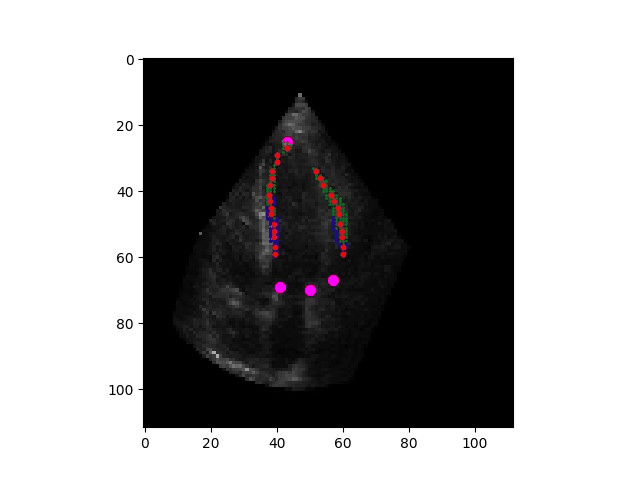

In [11]:
from IPython.display import Image, display

gif_path = '/content/frames_animation.gif'

display(Image(filename=gif_path))
